## 样式迁移
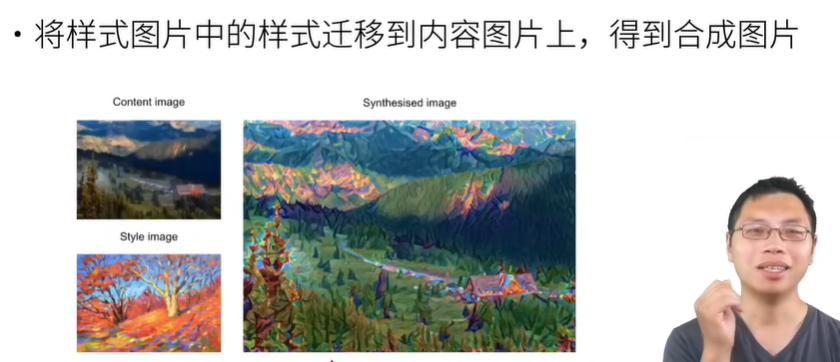

## 基于CNN的样式迁移

我们需要两张输入图像：一张是内容图像，另一张是样式图像。 我们将使用神经网络修改内容图像，使其在风格上接近风格图像。

首先，我们初始化合成图像，例如将其初始化为内容图像。 该合成图像是样式迁移过程中唯一需要更新的变量，即样式迁移所需迭代的模型参数。 

然后，我们选择一个预训练的卷积神经网络来抽取图像的特征，其中的模型参数在训练中无须更新。 这个深度卷积神经网络凭借多个层逐级抽取图像的特征，产生多个特征图，我们可以选择其中某些特征图作为内容特征或样式特征。

以下图为例：第一层和第三层卷积输出的特征图作为样式特征，第二层输出的特征图作为内容特征

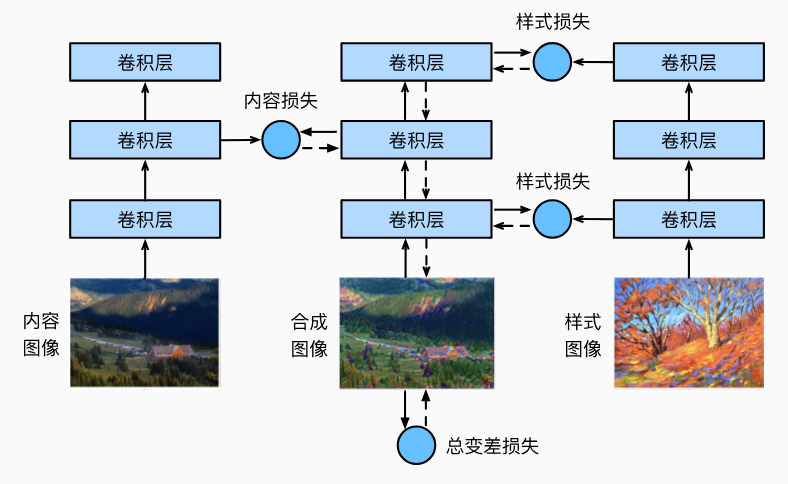

接下来，我们通过前向传播（实线箭头方向）计算样式迁移的损失函数，并通过反向传播（虚线箭头方向）迭代模型参数，即不断更新合成图像。 

样式迁移中常用的损失：1、内容损失，使合成图像与内容图像在内容特征上接近。 2、样式损失，使合成图像与样式图像在样式特征上接近。3、tv损失，有助于减少合成图像中的噪点

## 指定内容图片与样式图片

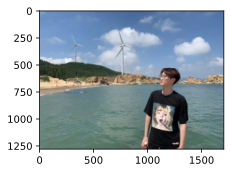

In [19]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
# 内容图片
content_img = d2l.Image.open('../img/rainier.jpg'.jpg')
d2l.plt.imshow(content_img)

In [20]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

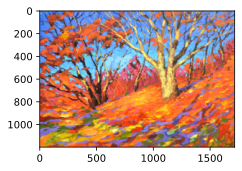

In [21]:
# 样式图片
style_img = d2l.Image.open('../img/autumn-oak.jpg')
d2l.plt.imshow(style_img);

## 预处理和后处理
 预处理函数preprocess对输入图像在RGB三个通道分别做标准化，并将结果变换成卷积神经网络接受的输入格式。 后处理函数postprocess则将输出图像中的像素值还原回标准化之前的值。 由于图像打印函数要求每个像素的浮点数值在0～1之间，我们对小于0和大于1的值分别取0和1。

In [22]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape), # 缩放图片尺寸
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(rgb_mean, rgb_std)
    ])
    
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

## 使用预训练网络抽取图像特征
使用基于ImageNet数据集预训练的VGG-19模型来抽取图像特征

In [23]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

 一般来说，越靠近输入层，越容易抽取图像的细节信息；反之，则越容易抽取图像的全局信息。 为了避免合成图像过多保留内容图像的细节，我们选择VGG较靠近输出的层，作为内容层（输出的特征图作为合成图像的内容特征）。 我们还从VGG中选择不同层的输出来匹配局部和全局的样式，这些层也称为样式层。

In [24]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

使用VGG层抽取特征时，我们只需要用到从输入层到最靠近输出层的内容层或风格层之间的所有层（此例仅需要使用0-28层）。 下面构建一个新的网络net，它只保留需要用到的VGG的所有层。

In [25]:
net = nn.Sequential(
        *[pretrained_net.features[i]
        for i in range(max(content_layers + style_layers) + 1)]
    )

给定输入的X，如果我们简单地调用前向传播net(X)，只能获得最后一层的输出。 由于我们需要中间层的输出，因此这里我们逐层计算，并保留内容层和风格层输出的特征图。

In [26]:
def extract_features(X, content_layers, style_layers):
    """求输入图像X在内容层和样式层输出的特征图"""
    # 保留内容层和样式层输出的特征图
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    
    return contents, styles

下面定义两个函数：get_contents函数对内容图像抽取出在内容层输出的特征； get_styles函数对样式图像抽取在样式层输出的特征。我们不断更新合成图像的像素值，就是为了使得合成图像在内容层/样式层的输出接近与内容图像, 样式图像在相应层的输出。（执行完这两个函数相当于获得了合成图像在训练时需要用到的标签了）

因为在训练时无须改变预训练的VGG的模型参数，所以我们可以在训练开始之前就提取出内容特征和风格特征（作为标签）。 由于合成图像是样式迁移所需迭代的模型参数，我们只能在训练过程中通过调用extract_features函数来抽取合成图像的内容特征和样式特征（获取预测值）。

内容特征：在内容层输出的特征图。样式特征：在样式层输出的特征图。

In [27]:
# 获取训练时用的标签
def get_contents(image_shape, device):
    """从内容图像抽取内容特征"""
    # 转化成网络需要的输入格式
    content_X = preprocess(content_img, image_shape).to(device)
    # 这里的contents_Y为内容图像在内容层的输出，起到标签的效果，我们不需要关心内容图像的样式
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    """从样式图像抽取样式特征"""
    style_X = preprocess(style_img, image_shape).to(device)
    # 这里的styles_Y为样式图像在样式层的输出，起到标签的效果，我们不需要关心样式图像的内容
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## 定义损失函数
下面我们来描述样式迁移的损失函数。 它由内容损失、风格损失和全变分损失3部分组成。

### 1、内容损失
内容损失通过均方误差函数衡量合成图像与内容图像在内容特征上的差异。

In [28]:
def content_loss(Y_hat, Y):
    # 将内容特征Y从计算图中剥离，这是一个常量
    return torch.square(Y_hat - Y.detach()).mean()

### 2、样式损失
样式损失与内容损失类似，也通过均平误差函数衡量合成图像与样式图像在样式上的差异。

In [29]:
def gram(X):
    """计算格拉姆矩阵：表达样式特征"""
    # n是每个通道的特征数，也就是像素个数, n = hw
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    # 特征图转换为矩阵
    X = X.reshape((num_channels, n))
    # 为了让风格损失不受这些值的大小影响，除以了矩阵中元素的个数
    # gram矩阵
    return torch.matmul(X, X.T) / (num_channels * n)

In [12]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

### 3、全变分损失（tv损失）
有时候，我们学到的合成图像里面有大量高频噪点，即有特别亮或者特别暗的颗粒像素。一种常见的去噪方法是全变分去噪。

In [30]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

样式转移的损失函数是内容损失、样式损失和全变化损失的加权和。通过调节这些权重超参数，我们可以权衡合成图像在保留内容、迁移风格以及去噪三方面的相对重要性。

In [31]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, 
                 contents_Y, styles_Y_gram):
    """计算样式迁移的损失"""
    contents_l = [content_loss(Y_hat, Y) * content_weight 
                  for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
    
    styles_l = [style_loss(Y_hat, Y) * style_weight 
                for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)]
    
    tv_l = tv_loss(X) * tv_weight
    
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## 初始化合成图像
在样式迁移中，合成的图像是训练期间唯一需要更新的变量。因此，我们可以定义一个简单的模型SynthesizedImage，并将合成的图像视为模型参数。模型的前向传播只需返回模型参数（合成图像tensor）。

In [32]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        # 合成图像的每个像素值是需要迭代的模型参数
        self.weight = nn.Parameter(torch.rand(*img_shape))
    
    def forward(self):
        return self.weight

下面，我们定义get_inits函数。该函数创建了合成图像的模型实例，并将其初始化为图像X。样式图像在各个样式层的格拉姆矩阵styles_Y_gram将在训练前预先计算好。

In [33]:
def get_inits(X, device, lr, styles_Y):
    """将合成图像初始为X，获取优化器，将样式特征变为gram矩阵"""
    gen_img = SynthesizedImage(X.shape).to(device)
    # 初始化为图像X
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    # 生成样式图像的各样式层的格拉姆矩阵
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

## 训练模型
在训练模型进行样式迁移时，我们不断抽取合成图像的内容特征和风格特征，然后计算损失。下面定义了训练循环。

In [34]:
def train(X, contents_Y, styles_Y, 
          device, lr, num_epochs, lr_decay_epoch):
    
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, 
                                                lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    
    for epoch in range(num_epochs):
        trainer.zero_grad()
        # 合成图像的内容特征、样式特征
        contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers
            )
        # 计算损失
        contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, 
                contents_Y, styles_Y_gram
            )
        l.backward()
        trainer.step()
        scheduler.step()
        
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
            
    return X

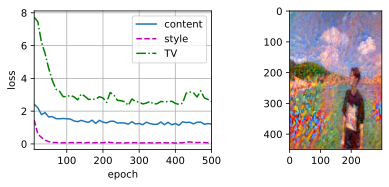

In [35]:
device, image_shape = d2l.try_gpu(), (450, 300)
net = net.to(device)
# 获取内容特征，使用内容图像初始化合成图像
content_X, contents_Y = get_contents(image_shape, device)
# 获取样式特征
_, styles_Y = get_styles(image_shape, device)

output = train(content_X, contents_Y, styles_Y, device, 
               lr=0.3, num_epochs=500, lr_decay_epoch=500)

我们可以看到，合成图像保留了样式图像的风景和物体，并同时迁移了风格图像的色彩。例如，合成图像具有与样式图像中一样的色彩块，其中一些甚至具有画笔笔触的细微纹理。